In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan
%matplotlib inline

/Users/yuki.ohnishi/.pyenv/versions/analysis/lib/python3.5/site-packages/Cython/Distutils/old_build_ext.py:30: UserWarning: Cython.Distutils.old_build_ext does not properly handle dependencies and is deprecated.
  "Cython.Distutils.old_build_ext does not properly handle dependencies "


#### 7.2 対数をとるか否か

In [2]:
df2 = pd.read_csv("input/data-rental.txt")

In [3]:
df2.head(2)

,Y,Area
0,263.062,40.66
1,519.000,61.94


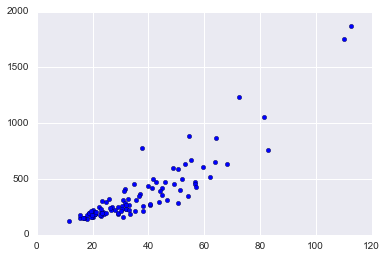

In [6]:
plt.scatter(df2.Area, df2.Y)

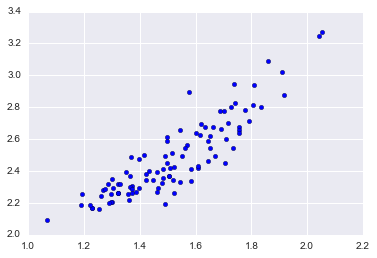

In [15]:
plt.scatter(np.log10(df2.Area), np.log10(df2.Y))

x, y軸が対数スケールになってるが、気にしない

In [21]:
Area_new = np.arange(1, 120)
data71 = {"N":len(df2), "Area":df2.Area, "Y":df2.Y, "Area_new":Area_new, "N_new":len(Area_new)}
fit71 = pystan.stan(file="stan/model7-1.stan", data=data71, seed=1234)

In [22]:
data72 = {"N":len(df2), "Area":np.log10(df2.Area), "Y":np.log10(df2.Y), "Area_new":np.log10(Area_new), "N_new":len(Area_new)}
fit72 = pystan.stan(file="stan/model7-2.stan", data=data72, seed=1234)

In [23]:
ms1 = fit71.extract()
ms2 = fit72.extract()

In [26]:
y1_new =ms1["y_new"].T
y2_new =ms2["y_new"].T

In [42]:
df_y1_new = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist() for x in y1_new],columns=["p10","p25","p50","p75","p90"])
df_y2_new = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist()  for x in y2_new],columns=["p10","p25","p50","p75","p90"])

(0, 120)

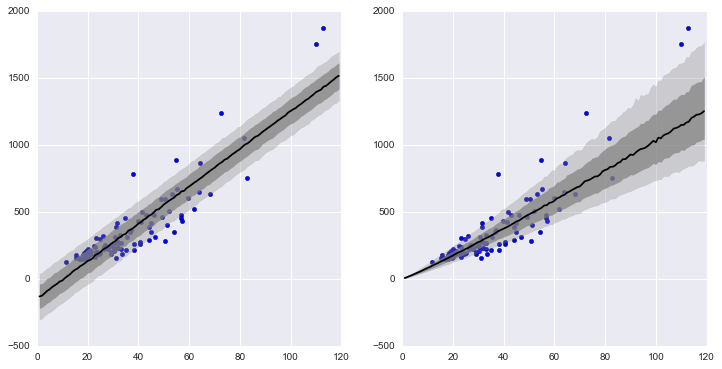

In [64]:
plt.figure(figsize=(12,6))
ax1 = plt.subplot(1,2,1)
ax1.scatter(df2.Area, df2.Y)
ax1.plot(Area_new, df_y1_new.p50,color="black")
ax1.fill_between(Area_new, df_y1_new.p10, df_y1_new.p90, color="gray", alpha=0.3)
ax1.fill_between(Area_new, df_y1_new.p25, df_y1_new.p75, color="gray", alpha=0.7)
ax1.set_xlim(0,120)
ax2 = plt.subplot(1,2,2)
ax2.scatter(df2.Area, df2.Y)
ax2.plot(Area_new, 10 ** df_y2_new.p50,color="black")
ax2.fill_between(Area_new, 10 ** df_y2_new.p10, 10 ** df_y2_new.p90, color="gray", alpha=0.3)
ax2.fill_between(Area_new, 10 ** df_y2_new.p25, 10 ** df_y2_new.p75, color="gray", alpha=0.7)
ax2.set_xlim(0,120)

左80%ベイズ予測区間が負の値を含む

In [83]:
y1_pred =ms1["y_pred"].T
y2_pred =ms2["y_pred"].T
df_y1_pred = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist() for x in y1_pred],columns=["p10","p25","p50","p75","p90"])
df_y2_pred = pd.DataFrame([np.percentile(x,[10,25,50,75,90]).tolist()  for x in y2_pred],columns=["p10","p25","p50","p75","p90"])
df_y1_pred["y_true"] = df2.Y
df_y2_pred["y_true"] = np.log10(df2.Y)
df_y2_pred = 10 ** df_y2_pred

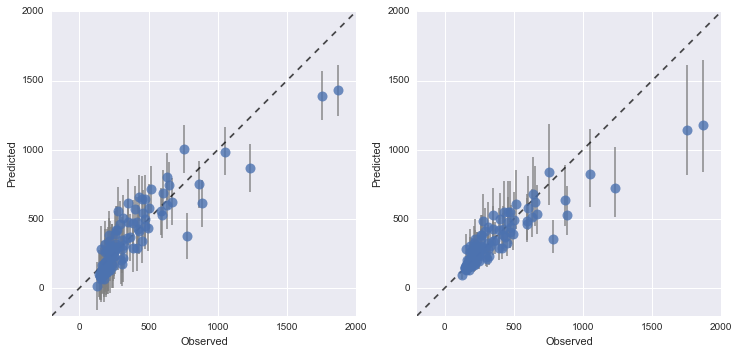

In [85]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,2,1)
ax.plot([-200,2000], [-200,2000], 'k--', alpha=0.7)
ax.errorbar(df_y1_pred.y_true, df_y1_pred.p50, yerr=[df_y1_pred.p50 - df_y1_pred.p10, df_y1_pred.p90 - df_y1_pred.p50],
    fmt='o', ecolor='gray', ms=10, alpha=0.8, marker='o')
ax.set_aspect('equal')
ax.set_xlim(-200, 2000)
ax.set_ylim(-200, 2000)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

ax = fig.add_subplot(1,2,2)
ax.plot([-200,2000], [-200,2000], 'k--', alpha=0.7)
ax.errorbar(df_y2_pred.y_true, df_y2_pred.p50, yerr=[df_y2_pred.p50 - df_y2_pred.p10, df_y2_pred.p90 - df_y2_pred.p50],
    fmt='o', ecolor='gray', ms=10, alpha=0.8, marker='o')
ax.set_aspect('equal')
ax.set_xlim(-200, 2000)
ax.set_ylim(-200, 2000)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

In [90]:
df_y1_pred = df_y1_pred.assign(eps=lambda df:df.y_true-df.p50)
df_y2_pred = df_y2_pred.assign(eps=lambda df:np.log10(df.y_true)-np.log10(df.p50))

/Users/yuki.ohnishi/.pyenv/versions/analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


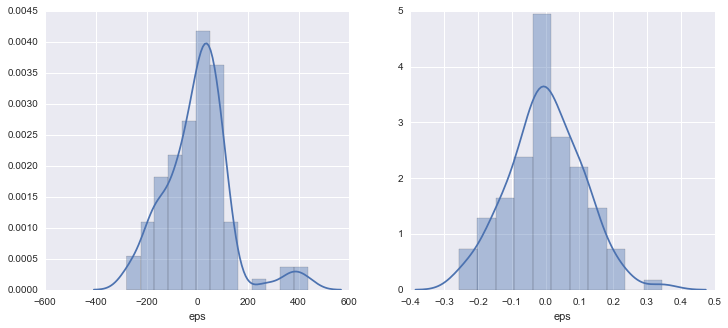

In [102]:
fig = plt.figure(figsize=(12,5))
ax1= fig.add_subplot(1,2,1)
ax1= sns.distplot(df_y1_pred.eps)
ax2= fig.add_subplot(1,2,2)
ax2= sns.distplot(df_y2_pred.eps,ax=ax2)
plt.show()

左正規分布から歪んでいる：1000万円の30%の誤差が大きく分布を歪める。一方、対数スケールで撮ると、その誤差が緩和される。

どちらを取るかは背景のメカニズム次第。対数スケールを取るのは倍々で増える仕組みが考えられる時など。

#### 7.3 非線形な関係

In [2]:
df3 = pd.read_csv("input/data-aircon.txt")

In [3]:
df3.head()

,X,Y
0,-2.1,98.2
1,-1.9,109.3
2,-1.3,95.4
3,-1.4,93.5
4,-1.3,95.5


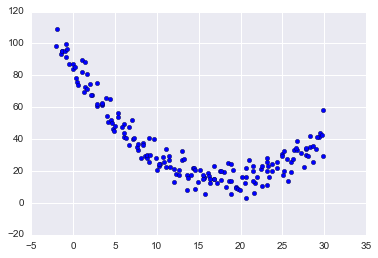

In [4]:
plt.scatter(df3.X, df3.Y)

In [18]:
X_new_73 = np.arange(-5,35)
data73 = {"N":len(df3), "X":df3.X, "Y":df3.Y, "N_new":len(X_new_73), "X_new":X_new_73}
fit3 = pystan.stan(file="stan/model7-3.stan", data=data73, seed=1234)

In [19]:
ms3 = fit3.extract()

In [20]:
y3_new = ms3["y_new"].T

In [21]:
y3_new.shape

(40, 4000)

In [22]:
df3_new = pd.DataFrame([np.percentile(x, [10,25,50,75,90]).tolist() for x in y3_new] ,columns=["p10","p25","p50","p75","p90"])

(-5, 35)

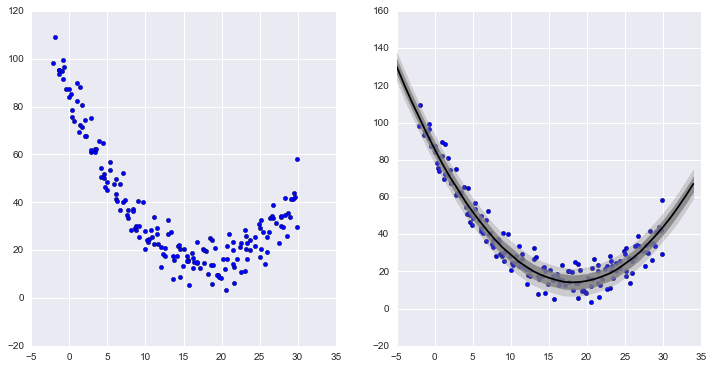

In [29]:
fig75 = plt.figure(figsize=(12,6))
ax1 = fig75.add_subplot(1,2,1)
ax1.scatter(df3.X, df3.Y)
ax1.set_xlim(-5,35)
ax2 = fig75.add_subplot(1,2,2)
ax2.scatter(df3.X, df3.Y)
ax2.plot(X_new_73, df3_new.p50,color="black")
ax2.fill_between(X_new_73, df3_new.p25, df3_new.p75, color="gray", alpha=0.8)
ax2.fill_between(X_new_73, df3_new.p10, df3_new.p90, color="gray", alpha=0.3)
ax2.set_xlim(-5,35)

時系列データ

In [30]:
df_conc = pd.read_csv("input/data-conc.txt")

In [31]:
df_conc

,Time,Y
0,1,2.4
1,2,5.0
2,4,7.5
3,8,11.9
4,12,12.5
5,24,12.7


In [45]:
X_new_conc = np.arange(0,25)
data74 = {"T":len(df_conc), "Time":df_conc.Time, "Y":df_conc.Y, "T_new":len(X_new_conc), "Time_new":X_new_conc}
fit74 = pystan.stan(file="stan/model7-4.stan", data=data74, seed=1234)

In [46]:
ms74 = fit74.extract()
y74_new = ms74["y_new"].T
df74_new = pd.DataFrame([np.percentile(x, [10,25,50,75,90]).tolist() for x in y74_new] ,columns=["p10","p25","p50","p75","p90"])

In [47]:
df74_new.head()

,p10,p25,p50,p75,p90
0,-1.001514,-0.467649,0.017008,0.506849,1.031773
1,1.732044,2.299285,2.798438,3.320784,3.979204
2,3.889469,4.463062,4.981377,5.552983,6.261971
3,5.556128,6.143009,6.692339,7.256204,7.979612
4,6.848756,7.468017,8.022811,8.584176,9.285079


(-2, 16)

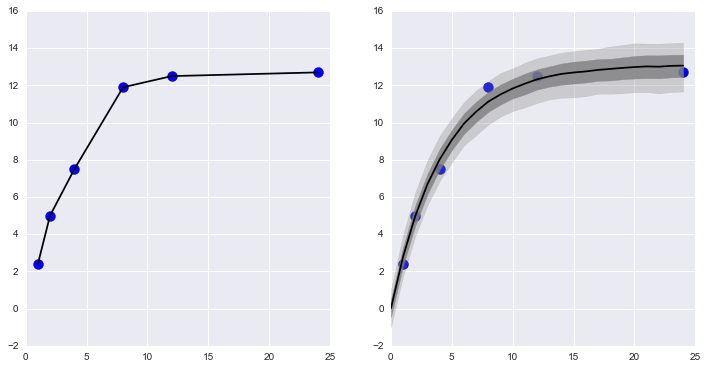

In [49]:
fig76 = plt.figure(figsize=(12,6))
ax1 = fig76.add_subplot(1,2,1)
ax1.scatter(df_conc.Time, df_conc.Y, s=100)
ax1.plot(df_conc.Time, df_conc.Y, "k-")
ax1.set_xlim(0,25)
ax1.set_ylim(-2,16)
ax2 = fig76.add_subplot(1,2,2)
ax2.scatter(df_conc.Time, df_conc.Y, s=100)
ax2.plot(X_new_conc, df74_new.p50,color="black")
ax2.fill_between(X_new_conc, df74_new.p25, df74_new.p75, color="gray", alpha=0.8)
ax2.fill_between(X_new_conc, df74_new.p10, df74_new.p90, color="gray", alpha=0.3)
ax2.set_xlim(0,25)
ax2.set_ylim(-2,16)

#### 7.5 交絡

In [2]:
df75= pd.read_csv("input/data-50m.txt")

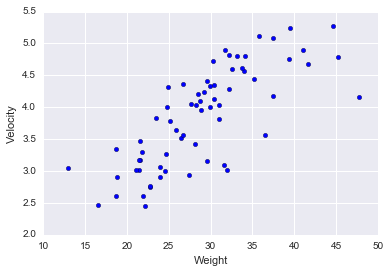

In [5]:
plt.scatter(df75.Weight, df75.Y)
plt.xlabel("Weight")
plt.ylabel("Velocity")

In [6]:
df75.head()

,Y,Weight,Age
0,2.46,16.6,7
1,3.02,21.4,7
2,2.91,24.0,7
3,3.05,13.0,7
4,2.60,21.9,7


In [52]:
data75 = {"N":len(df75), "Weight":df75.Weight, "Age":df75.Age, "Y":df75.Y}
fit75 = pystan.stan(file="stan/model7-5.stan", data=data75, seed=1234,pars=["c2", "b2", "b3"])

In [53]:
ms75 = fit75.extract()
c2 = ms75["c2"].T
b2 = ms75["b2"].T
b3 = ms75["b3"].T

In [65]:
c2.shape

(4000,)

In [67]:
c2_low, c2_med, c3_upp =  np.percentile(c2, [2.5, 50, 97.5])
b2_low, b2_med, b2_upp = np.percentile(b2, [2.5, 50, 97.5])
b3_low, b3_med, b3_upp = np.percentile(b3, [2.5, 50, 97.5])

In [69]:
print(c2_low, c2_med, c3_upp) # 体重への年齢の影響（正）
print(b2_low, b2_med, b2_upp) # 速さへの年齢の影響（正）
print(b3_low, b3_med, b3_upp) # 速さへの体重の影響（負）

3.45126378375 3.93788394936 4.46756908646
0.498309337125 0.588092002028 0.680748673923
-0.0555473089828 -0.0347385705978 -0.0142846278254


#### 7.7 説明変数にノイズを含む

In [7]:
df76 = pd.read_csv("input/data-salary.txt")

In [8]:
df76.head()

,X,Y
0,24,472
1,24,403
2,26,454
3,32,575
4,33,546


In [78]:
data76 = {"N":len(df76), "X":df76.X, "Y":df76.Y}
fit76 = pystan.stan(file="stan/model7-6.stan", data=data76, seed=1234)

In [79]:
fit76

Inference for Stan model: anon_model_0d49670ff450f47a654e65de5873fedf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a          -125.3    2.67  74.08 -271.1 -172.8 -123.5 -76.64  22.57    770    1.0
b           22.03    0.06   1.64  18.73  20.98  22.02  23.06  25.23    770    1.0
x_true[0]   25.48    0.06   2.05  21.25  24.12  25.56   26.9  29.32   1002    1.0
x_true[1]   24.02    0.05   1.94  20.23  22.68  24.01  25.35  27.84   1334    1.0
x_true[2]   26.19    0.06   1.97  22.33  24.85  26.21  27.52  30.01   1216    1.0
x_true[3]   31.93    0.05   1.91  28.15  30.67  31.96  33.23   35.6   1209    1.0
x_true[4]   31.83    0.05   1.91  28.04  30.53  31.82  33.08  35.57   1258    1.0
x_true[5]    37.9    0.07   2.08  33.58  36.57   38.0  39.37  41.67    938    1.0
x_true[6]   38.81    0.05   1.88  35.07  37.61  38.83  40.13  42.37   133

#### 7.8 打ち切り

In [2]:
df77 = pd.read_csv("input/data-protein.txt")

In [3]:
df77

,Y
0,<25
1,32.3
2,<25
3,28.3
4,30.8
5,35.2


In [11]:
Y_obs

['32.3', '28.3', '30.8', '35.2']

In [37]:
df77["flg"] = df77.Y.str.contains("<")
N_obs = len(df77[df77.flg ==False])
N_cens = len(df77[df77.flg ==True])
Y_obs = df77[df77.flg ==False].Y.astype(np.float).tolist()
L = 25 # 手抜き
data77 = {"N_obs":N_obs, "N_cens":N_cens, "Y_obs":Y_obs, "L":L}
fit77 = pystan.stan(file="stan/model7-7.stan", data=data77, seed=1234)

In [38]:
fit77

Inference for Stan model: anon_model_f54576c979baed873782e47bdfbe16a3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu     24.77    0.53  10.93  -2.44  23.04  27.08  29.65   36.8    433   1.01
sigma  14.87    0.75  16.56   3.92   6.72   9.79   16.6  60.05    485   1.01
lp__  -10.26    0.07   1.44  -14.3  -10.8  -9.84  -9.21  -8.84    445   1.01

Samples were drawn using NUTS at Fri Nov 25 01:44:17 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

#### 7.9 外れ値

In [12]:
df79 = pd.read_csv("input/data-outlier.txt")

In [17]:
X_new_79 = np.arange(0,11)
data79 = {'N':len(df79), 'X':df79.X, 'Y': df79.Y, "N_new": len(X_new_79), "X_new":X_new_79}
fit79 = pystan.stan(file='stan/model7-9.stan', data=data79, seed=1234)

In [21]:
ms79 = fit79.extract()
y79_new = ms79["y_new"].T

In [23]:
y79_new.shape

(11, 4000)

In [32]:
df79_new = pd.DataFrame([np.percentile(x,[2.5,25,50,75,97.5]) for x in y79_new], columns=["p2.5","p25", "p50", "p75","p97.5"])

In [33]:
df79_new

,p2.5,p25,p50,p75,p97.5
0,-10.515856,-0.859187,-0.019352,0.918510,9.308082
1,-7.035456,3.235583,4.056023,5.018212,14.553643
2,-1.246830,7.305977,8.079959,8.996308,17.354179
3,1.517994,11.403579,12.154101,13.004125,21.876200
4,8.048620,15.426710,16.208000,17.001095,26.603722
5,10.823202,19.498295,20.244943,21.010429,31.016463
6,14.614646,23.579726,24.312814,25.054037,33.182010
7,20.173516,27.651824,28.381258,29.086568,39.312880
8,22.768130,31.622523,32.409944,33.095627,42.974339
9,25.110051,35.618659,36.473416,37.177525,47.424842


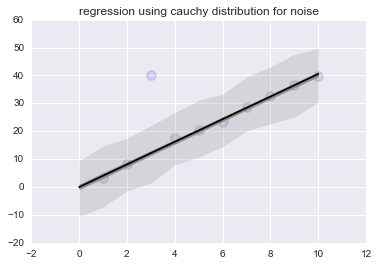

In [35]:
plt.title("regression using cauchy distribution for noise")
plt.scatter(df79.X, df79.Y, s=80, alpha=0.1, lw=2,edgecolors="black")
plt.plot(X_new_79, df79_new.p50, color="black")
plt.fill_between(X_new_79, df79_new.p25, df79_new.p75, color="gray", alpha=0.8)
plt.fill_between(X_new_79, df79_new["p2.5"], df79_new["p97.5"], color="gray", alpha=0.2)

ノイズの生成分布に裾の長いコーシー分布を使用することで、外れ値に対して、ロバストな予測ができている。